In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sma
import statsmodels.formula.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.vector_ar.vecm import coint_johansen
%matplotlib inline
sns.set()

In [2]:
#load data
df = pd.read_excel('AirQualityUCI.xlsx',parse_dates=[['Date','Time']])

In [3]:
#add year,month,day,hour columns from Date_Time columns for different time scale
df['year'] = [d.year for d in df.Date_Time]
df['month'] = [d.month for d in df.Date_Time]
df['day'] = [d.day for d in df.Date_Time]
df['hour'] = [d.hour for d in df.Date_Time]

In [4]:
#convert Date_Time to index and rename the index
df.set_index('Date_Time',inplace=True)
df.index.name = 'datetime'

In [5]:
#see data
df.head(3)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,year,month,day,hour
datetime,,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754,2004,3,10,18
2004-03-10 19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487,2004,3,10,19
2004-03-10 20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.9,53.975000,0.750239,2004,3,10,20


In [6]:
#missing value:-200 -> nan (python missing value data type)
df = df.replace(-200,np.nan)

In [7]:
#Data information 
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 17 columns):
CO(GT)           7674 non-null float64
PT08.S1(CO)      8991 non-null float64
NMHC(GT)         914 non-null float64
C6H6(GT)         8991 non-null float64
PT08.S2(NMHC)    8991 non-null float64
NOx(GT)          7718 non-null float64
PT08.S3(NOx)     8991 non-null float64
NO2(GT)          7715 non-null float64
PT08.S4(NO2)     8991 non-null float64
PT08.S5(O3)      8991 non-null float64
T                8991 non-null float64
RH               8991 non-null float64
AH               8991 non-null float64
year             9357 non-null int64
month            9357 non-null int64
day              9357 non-null int64
hour             9357 non-null int64
dtypes: float64(13), int64(4)
memory usage: 1.3 MB


In [8]:
#Drop columns that contain too many missing values
df.drop('NMHC(GT)',axis=1,inplace=True)

In [9]:
#impute missing value using next record
df.fillna(method='bfill',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 16 columns):
CO(GT)           9357 non-null float64
PT08.S1(CO)      9357 non-null float64
C6H6(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
year             9357 non-null int64
month            9357 non-null int64
day              9357 non-null int64
hour             9357 non-null int64
dtypes: float64(12), int64(4)
memory usage: 1.2 MB


In [10]:
#statistic summary
df.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,year,month,day,hour
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.179010,1103.261453,10.167377,941.616383,243.098782,832.651322,109.838613,1453.455417,1034.456485,18.147741,49.563462,1.021860,2004.240141,6.310356,15.876884,11.498557
std,1.470994,219.938898,7.535855,269.169877,208.776498,257.873913,47.624836,341.117185,409.193822,8.777165,17.214160,0.400088,0.427192,3.438160,8.808653,6.923182
min,0.100000,647.250000,0.149048,383.250000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.175000,0.184679,2004.000000,1.000000,1.000000,0.000000
25%,1.000000,936.750000,4.434582,734.250000,95.300000,652.750000,74.000000,1231.750000,736.750000,11.625000,36.275000,0.737445,2004.000000,3.000000,8.000000,5.000000
50%,1.900000,1068.750000,8.301413,911.500000,180.000000,802.750000,106.000000,1456.500000,972.500000,17.575000,50.175000,0.993346,2004.000000,6.000000,16.000000,11.000000
75%,3.000000,1241.500000,14.274696,1125.500000,316.000000,964.750000,138.000000,1662.000000,1291.500000,24.125000,62.925000,1.306671,2004.000000,9.000000,23.000000,18.000000
max,11.900000,2039.750000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036,2005.000000,12.000000,31.000000,23.000000


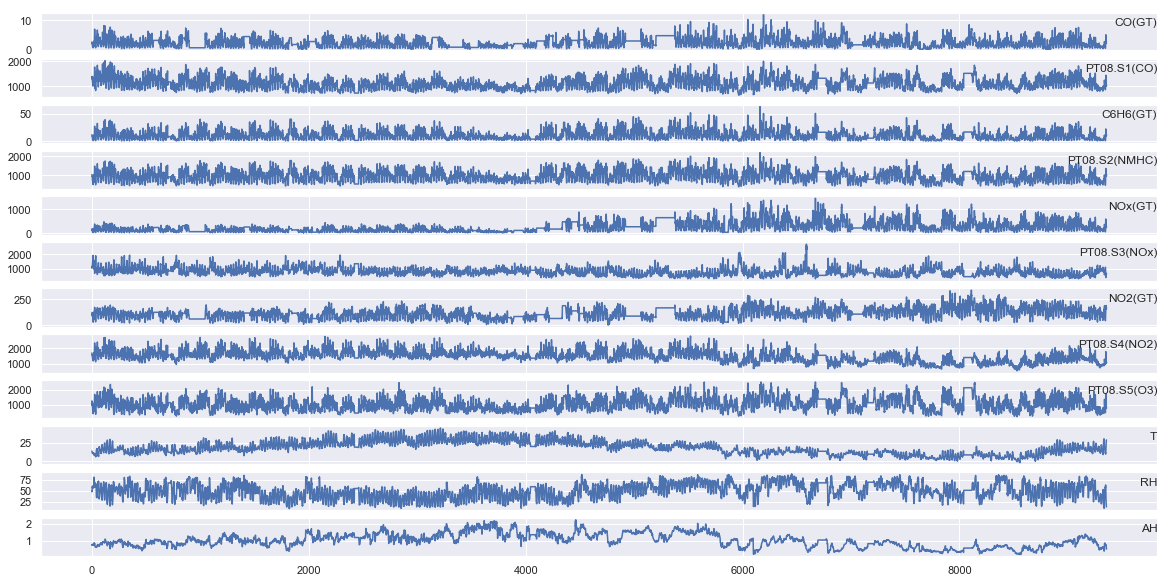

In [11]:
#plot time series
values = df.values
#specify columns to plot
groups = range(12)
i = 1
# plot each column
plt.figure(figsize=(20,10))
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

Text(0, 0.5, 'NO2(GT) (microg/m^3)')

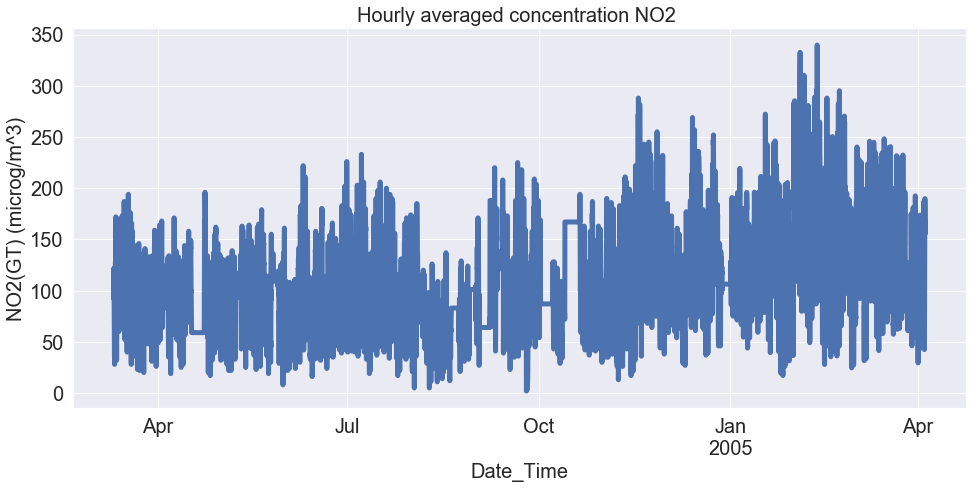

In [12]:
#plot hourly averaged concentration NO2
df['NO2(GT)'].plot(figsize=(12,6), linewidth=5, fontsize=20)
plt.title('Hourly averaged concentration NO2 ',fontsize=20)
plt.xlabel('Date_Time', fontsize=20);
plt.ylabel('NO2(GT) (microg/m^3)',fontsize=20)

In [13]:
#Group data by month,day,hour
month_df = df.groupby('month').mean()
day_df = df.groupby('day').mean()
hour_df = df.groupby('hour').mean()

Text(0, 0.5, 'NO2(GT) (microg/m^3)')

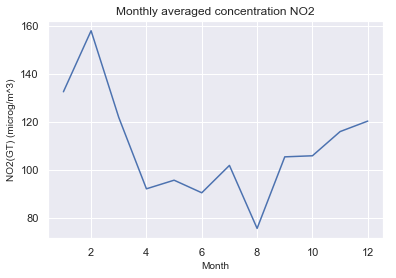

In [14]:
#monthly averaged concentration NO2
month_df['NO2(GT)'].plot()
plt.title('Monthly averaged concentration NO2')
plt.xlabel('Month', fontsize=10);
plt.ylabel('NO2(GT) (microg/m^3)',fontsize=10)

Text(0, 0.5, 'NO2(GT) (microg/m^3)')

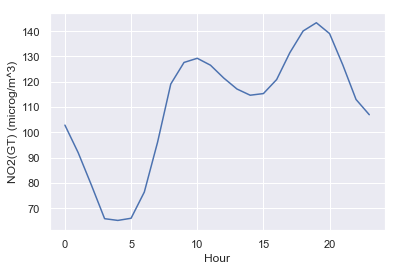

In [15]:
hour_df['NO2(GT)'].plot()
plt.xlabel('Hour')
plt.ylabel('NO2(GT) (microg/m^3)')

Text(0, 0.5, 'NO2(GT) (microg/m^3)')

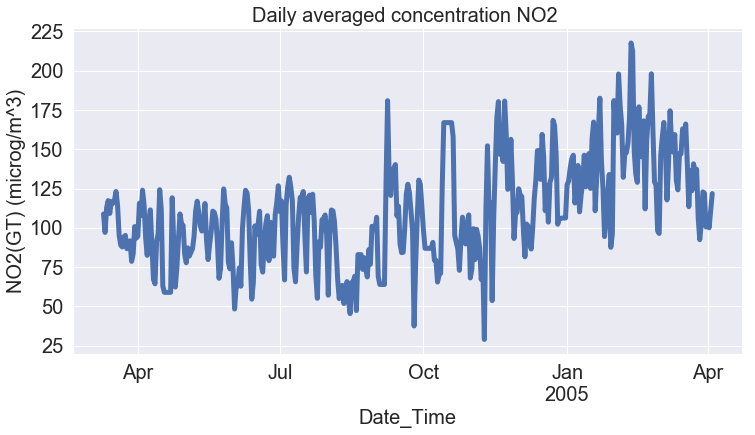

In [16]:
#resampling of day frequency
day_mean = df['NO2(GT)'].resample('D').mean()
day_mean.plot(figsize=(12,6), linewidth=5, fontsize=20)
plt.title('Daily averaged concentration NO2 ',fontsize=20)
plt.xlabel('Date_Time', fontsize=20);
plt.ylabel('NO2(GT) (microg/m^3)',fontsize=20)

Text(0, 0.5, 'Hourly averaged concentration NO2')

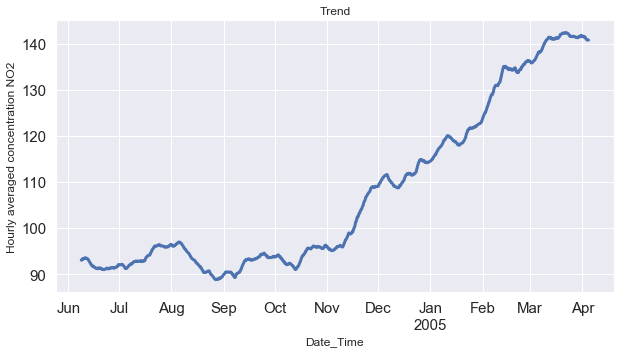

In [17]:
#Trend
df['NO2(GT)'].rolling(24*30*3).mean().plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.title('Trend')
plt.xlabel('Date_Time')
plt.ylabel('Hourly averaged concentration NO2')

Text(0, 0.5, 'Daily averaged concentration NO2')

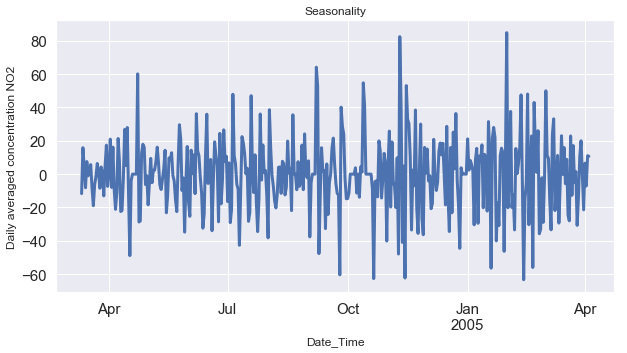

In [18]:
# Seasonality
day_mean.diff().plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.title('Seasonality')
plt.xlabel('Date_Time', );
plt.ylabel('Daily averaged concentration NO2')

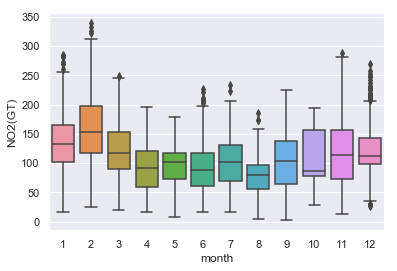

In [19]:
sns.boxplot(data=df, x='month', y='NO2(GT)')

Text(0, 0.5, 'r')

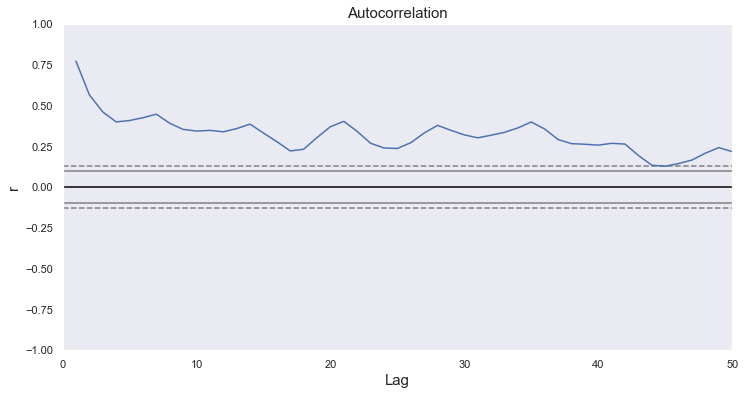

In [20]:
#Autocorrelation
plt.figure(figsize=(12,6))
pd.plotting.autocorrelation_plot(day_mean)
plt.xlim((0, 50)) #lag 7,14,21,28有高峰
plt.title('Autocorrelation',fontsize=15)
plt.xlabel('Lag',fontsize=15)
plt.ylabel('r',fontsize=15)

In [21]:
day_mean = df.iloc[:,:-4].resample('D').mean()
day_mean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 391 entries, 2004-03-10 to 2005-04-04
Freq: D
Data columns (total 12 columns):
CO(GT)           391 non-null float64
PT08.S1(CO)      391 non-null float64
C6H6(GT)         391 non-null float64
PT08.S2(NMHC)    391 non-null float64
NOx(GT)          391 non-null float64
PT08.S3(NOx)     391 non-null float64
NO2(GT)          391 non-null float64
PT08.S4(NO2)     391 non-null float64
PT08.S5(O3)      391 non-null float64
T                391 non-null float64
RH               391 non-null float64
AH               391 non-null float64
dtypes: float64(12)
memory usage: 39.7 KB


In [22]:
corr_pd = day_mean.corr()
corr_pd

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
CO(GT),1.000000,0.645873,0.696475,0.691049,0.714067,-0.511690,0.493270,0.329984,0.682488,-0.084675,0.354699,0.097802
PT08.S1(CO),0.645873,1.000000,0.778525,0.795707,0.533657,-0.674147,0.457185,0.428198,0.889513,-0.118588,0.413344,0.086529
C6H6(GT),0.696475,0.778525,1.000000,0.988913,0.513866,-0.616746,0.354385,0.596877,0.841658,0.161463,0.159699,0.230131
PT08.S2(NMHC),0.691049,0.795707,0.988913,1.000000,0.494665,-0.657301,0.349073,0.635522,0.856377,0.201164,0.157860,0.267125
NOx(GT),0.714067,0.533657,0.513866,0.494665,1.000000,-0.560222,0.743418,-0.137391,0.654502,-0.433956,0.498532,-0.176494
PT08.S3(NOx),-0.511690,-0.674147,-0.616746,-0.657301,-0.560222,1.000000,-0.465995,-0.288649,-0.746611,-0.059065,-0.320604,-0.271485
NO2(GT),0.493270,0.457185,0.354385,0.349073,0.743418,-0.465995,1.000000,-0.286824,0.584742,-0.491511,0.174639,-0.463820
PT08.S4(NO2),0.329984,0.428198,0.596877,0.635522,-0.137391,-0.288649,-0.286824,1.000000,0.317955,0.710024,0.015089,0.759284
PT08.S5(O3),0.682488,0.889513,0.841658,0.856377,0.654502,-0.746611,0.584742,0.317955,1.000000,-0.137853,0.305641,-0.001565
T,-0.084675,-0.118588,0.161463,0.201164,-0.433956,-0.059065,-0.491511,0.710024,-0.137853,1.000000,-0.480303,0.791667


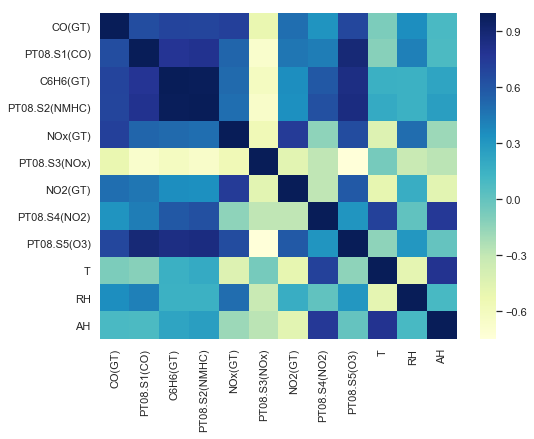

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_pd, cmap='YlGnBu')

In [24]:
#Johasen's test
ei_value= coint_johansen(day_mean,-1,1).eig
test_result = pd.DataFrame(ei_value,index=day_mean.columns,columns=['test_value'])

In [25]:
test_result

,test_value
CO(GT),0.332531
PT08.S1(CO),0.293419
C6H6(GT),0.264180
PT08.S2(NMHC),0.240447
NOx(GT),0.208847
PT08.S3(NOx),0.167128
NO2(GT),0.144862
PT08.S4(NO2),0.115956
PT08.S5(O3),0.060334
T,0.030851


In [26]:
#prepare for training data and validation data for VAR model
train = day_mean[:-5]
valid = day_mean[-5:]

In [27]:
train = train[['NO2(GT)','RH']]
valid = valid[['NO2(GT)','RH']]

In [28]:
#Build VAR model
model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

In [29]:
cols = train.columns
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,len(train.columns)):
    for i in range(0, len(prediction)):
        pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for NO2(GT) is :  11.976609235501634
rmse value for RH is :  15.185084215737259


In [30]:
pred

,NO2(GT),RH
0,118.781,53.6326
1,116.266,53.168
2,114.366,52.6892
3,112.95,52.2283
4,111.912,51.8042


In [31]:
pred.set_index(valid.index,inplace=True)

In [32]:
valid

,NO2(GT),RH
datetime,,
2005-03-31,100.637500,50.092708
2005-04-01,107.208333,35.959722
2005-04-02,100.079167,32.213542
2005-04-03,111.137500,33.686458
2005-04-04,121.840000,42.791667


In [33]:
x = pred['NO2(GT)']
y = valid['NO2(GT)']
var_result = pd.concat([x,y],axis=1)
var_result.columns=['Predict','Actual']

In [34]:
var_result

,Predict,Actual
datetime,,
2005-03-31,118.781,100.637500
2005-04-01,116.266,107.208333
2005-04-02,114.366,100.079167
2005-04-03,112.95,111.137500
2005-04-04,111.912,121.840000


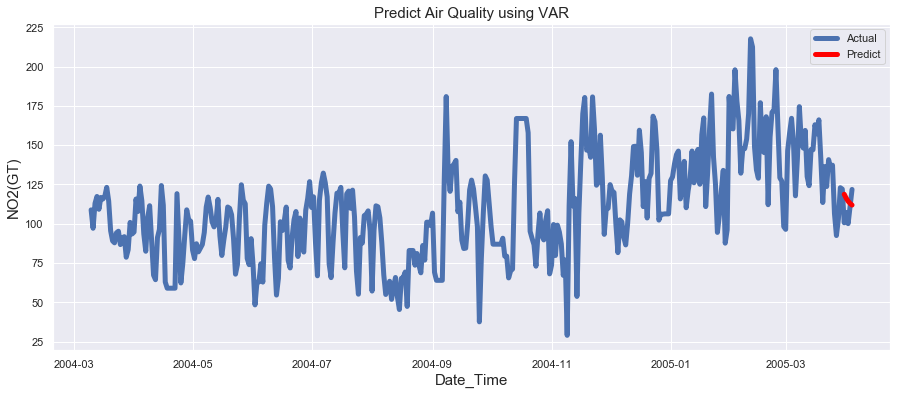

In [35]:
plt.figure(figsize=(15,6))
plt.plot(day_mean['NO2(GT)'],label='Actual',linewidth=5)
plt.plot(pred['NO2(GT)'],label='Predict',color='red',linewidth=5)
plt.title('Predict Air Quality using VAR',fontsize=15)
plt.legend(loc='upper right')
plt.xlabel('Date_Time',fontsize=15)
plt.ylabel('NO2(GT)',fontsize=15)
plt.show()

In [36]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 03, Apr, 2019
Time:                     17:43:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.2142
Nobs:                     385.000    HQIC:                   10.1770
Log likelihood:          -3040.95    FPE:                    25656.5
AIC:                      10.1526    Det(Omega_mle):         25261.3
--------------------------------------------------------------------
Results for equation NO2(GT)
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             31.557464         5.088383            6.202           0.000
L1.NO2(GT)         0.784969         0.032762           23.960           0.000
L1.RH             -0.159064         0.083020           -1.916         

In [37]:
#Prepare for training data and validation data for Linear Regression model
lr_data = day_mean[['NO2(GT)','RH']].copy()
lr_data.head(3)

,NO2(GT),RH
datetime,,
2004-03-10,108.833333,54.883334
2004-03-11,97.125000,64.069791
2004-03-12,113.000000,51.107292


In [38]:
cols = lr_data.columns
for name in cols:
    for i in range(5,8):
        lr_data["lag_{}_{}".format(name,i)] = lr_data[name].shift(i)

In [39]:
lr_data.head(10)

,NO2(GT),RH,lag_NO2(GT)_5,lag_NO2(GT)_6,lag_NO2(GT)_7,lag_RH_5,lag_RH_6,lag_RH_7
datetime,,,,,,,,
2004-03-10,108.833333,54.883334,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-11,97.125000,64.069791,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-12,113.000000,51.107292,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-13,117.375000,51.530903,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-14,109.208333,48.843750,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-15,116.750000,50.320833,108.833333,NaN,NaN,54.883334,NaN,NaN
2004-03-16,115.708333,44.825000,97.125000,108.833333,NaN,64.069791,54.883334,NaN
2004-03-17,117.458333,41.165625,113.000000,97.125000,108.833333,51.107292,64.069791,54.883334
2004-03-18,123.166667,44.084722,117.375000,113.000000,97.125000,51.530903,51.107292,64.069791


In [40]:
lr_data = lr_data[7:]
train_data = lr_data[:-5]
valid_data = lr_data[-5:]

In [41]:
x_train = train_data.drop(cols,axis=1)
y_train = train_data['NO2(GT)']
x_val = valid_data.drop(cols,axis=1)
y_val = valid_data['NO2(GT)']

In [42]:
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((379, 6), (5, 6), (379,), (5,))

In [43]:
X_train = sma.add_constant(x_train) ## let's add an intercept (beta_0) to our model
X_test = sma.add_constant(x_val)

In [44]:
lm = sm.OLS(y_train,X_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NO2(GT)   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     21.74
Date:                Wed, 03 Apr 2019   Prob (F-statistic):           6.33e-22
Time:                        17:43:48   Log-Likelihood:                -1805.8
No. Observations:                 379   AIC:                             3626.
Df Residuals:                     372   BIC:                             3653.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            44.4975      7.854      5.666      0.000      29.054      59.941
lag_NO2(GT)_5     0.2060      0.072      2.874      0.004       0.065       0.347
lag_NO2(GT)_6     0.0723      0.094      0.769      0.442      -0.113       0.257
lag_NO2(GT)_7     0.2870      0.073      3.932      0.000       0.144       0.431
lag_RH_5         -0.2674      0.196     -1.367      0.172      -0.652       0.117
lag_RH_6         -0.2349      0.256     -0.917      0.360      -0.739       0.269
lag_RH_7          0.5682      0.192      2.960      0.003       0.191       0.946
==============================================================================
Omnibus:                       13.774   Durbin-Watson:                   0.639
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.250
Skew:                           0.448   Prob(JB):                     0.000805
Kurtosis:                       3.315   Cond. No.                     1.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
y_pred = lm.predict(X_test)
print('rmse value for', sqrt(mean_squared_error(y_pred, y_val)))

rmse value for 7.507639388279131


In [46]:
x2 = y_pred
y2 = y_val
lr_result = pd.concat([x2,y2],axis=1)
lr_result.columns=['Predict','Actual']

In [47]:
lr_result

,Predict,Actual
datetime,,
2005-03-31,113.270144,100.637500
2005-04-01,113.341768,107.208333
2005-04-02,102.612004,100.079167
2005-04-03,113.988292,111.137500
2005-04-04,113.468724,121.840000


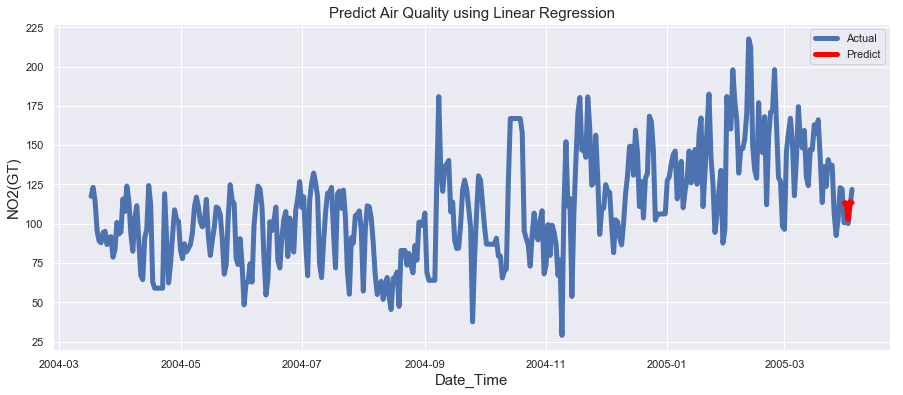

In [48]:
plt.figure(figsize=(15,6))
plt.plot(lr_data['NO2(GT)'],label='Actual',linewidth=5)
plt.plot(y_pred,label='Predict',color='red',linewidth=5)
plt.title('Predict Air Quality using Linear Regression',fontsize=15)
plt.legend(loc='upper right')
plt.xlabel('Date_Time',fontsize=15)
plt.ylabel('NO2(GT)',fontsize=15)
plt.show()